In [1]:
import galsim
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def ab2adu(magAB,zero_point,extinction,exposure_time):    
    airmass = 1.0 # ?? 
    airmass0 =1.3 # for DES i-band
    magAB += extinction*(airmass-airmass0)
    return exposure_time*zero_point*10**(-0.4*(magAB-24))

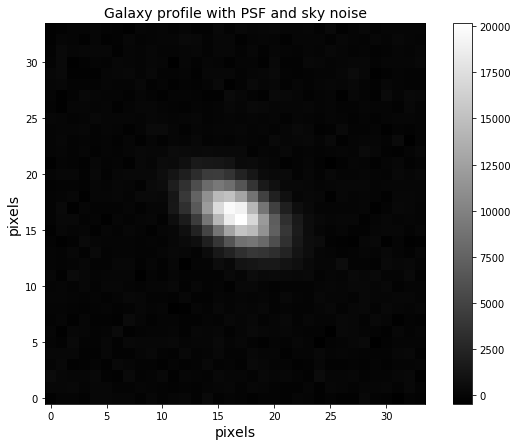

In [2]:
# survey info
# values pirated from
# https://github.com/ismael2395/WLD/blob/7d7194cd37d55a30bd2710b8fc1cf1b0075949a8/descwl/survey.py
pixel_scale = 0.263                                   # DES Pixel scale in arcsec/pixel
zp = 13.94                                            # ADU for a 24th DES i-mag object and airmass=1.3
expt = 1000.                                          # exposure time (DES i-band)
extinction = 0.05                                     # MilkyWay extinction (DES i-band)
sky_brightness = 20.5                                 # AB mag/arcsec^2 (DES i-band)
sky_level = ab2adu(sky_brightness,zp,extinction,expt) # ADU/arcsec^2
sky_level *= pixel_scale**2                           # ADU/pixel

# galaxy info
gal_hlr = 0.55                                        # half light radious in arcsec
imag = 20.                                            # galaxy AB mag (DES i-band); extinction-corrected
e1, e2 = 0.15, -0.3                                   # galaxy shapes (epsilon-ellipticities)
psf_fwhm = 0.6                                        # arcsec
flux_ADU = ab2adu(imag,zp,extinction,expt)            # flux in ADU

# galsim adjustments
random_seed = 1234567
rng = galsim.BaseDeviate(random_seed)

# create a galaxy
gal = galsim.Gaussian(flux=flux_ADU,half_light_radius=gal_hlr)

# add ellipticity info to galaxy
gal = gal.shear(g1=e1,g2=e2)

# create psf
psf = galsim.Gaussian(flux=1.,fwhm=psf_fwhm)

# convolve galaxy with psf
gal_convolved = galsim.Convolve([gal, psf])

# make images with psf and noise
image_gal = gal.drawImage(scale=pixel_scale,method='fft')
image_gal_convolved = gal_convolved.drawImage(scale=pixel_scale,method='fft')
image_gal_convolved_w_noise = image_gal_convolved.copy()
image_gal_convolved_w_noise.addNoise(galsim.PoissonNoise(rng=rng,sky_level=sky_level))

# draw the final image
fig = plt.figure(figsize=(10,7))
plt.imshow(image_gal_convolved_w_noise.array,origin='lower',cmap=cm.gray)
plt.title('Galaxy profile with PSF and sky noise',fontsize=14)
plt.xlabel('pixels',fontsize=14)
plt.ylabel('pixels',fontsize=14)
plt.colorbar()